In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
)
import kagglehub
import torchinfo
from collections import Counter
import numpy as np

In [ ]:
# Download latest version
# path = kagglehub.dataset_download(
#     "tawsifurrahman/tuberculosis-tb-chest-xray-dataset"
# )

# print("Path to dataset files:", path)

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
val_test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

data_dir = "data/TB_Chest_Radiography_Database"
full_dataset = datasets.ImageFolder(data_dir, transform=val_test_transform)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    val_dataset, batch_size=8, shuffle=False, num_workers=4
)
test_loader = DataLoader(
    test_dataset, batch_size=8, shuffle=False, num_workers=4
)

labels = [label for _, label in full_dataset.samples]
class_counts = Counter(labels)

print(f"Số lớp: {len(full_dataset.classes)}")
print(f"Lớp: {full_dataset.classes}")
for class_idx, count in class_counts.items():
    print(f"Lớp {full_dataset.classes[class_idx]}: {count} mẫu")
print(f"Số mẫu train: {len(train_dataset)}")
print(f"Số mẫu validation: {len(val_dataset)}")
print(f"Số mẫu test: {len(test_dataset)}")

# Hiển thị phân bố lớp trong từng tập dữ liệu
print("\nPhân bố lớp trong từng tập dữ liệu:")

# Hàm đếm số lượng mẫu theo lớp
def count_classes(dataset):
    class_counts = {class_name: 0 for class_name in full_dataset.classes}
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        class_name = full_dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

# Đếm và hiển thị số lượng mẫu theo lớp trong từng tập
print("\nTập huấn luyện (Train):")
train_class_counts = count_classes(train_dataset)
for class_name, count in train_class_counts.items():
    print(f"Lớp {class_name}: {count} mẫu")

print("\nTập kiểm định (Validation):")
val_class_counts = count_classes(val_dataset)
for class_name, count in val_class_counts.items():
    print(f"Lớp {class_name}: {count} mẫu")

print("\nTập kiểm tra (Test):")
test_class_counts = count_classes(test_dataset)
for class_name, count in test_class_counts.items():
    print(f"Lớp {class_name}: {count} mẫu")

Số lớp: 2
Lớp: ['Normal', 'Tuberculosis']
Lớp Normal: 3500 mẫu
Lớp Tuberculosis: 700 mẫu
Số mẫu train: 2940
Số mẫu validation: 840
Số mẫu test: 420

Phân bố lớp trong từng tập dữ liệu:

Tập huấn luyện (Train):
Lớp Normal: 2450 mẫu
Lớp Tuberculosis: 490 mẫu

Tập kiểm định (Validation):
Lớp Normal: 697 mẫu
Lớp Tuberculosis: 143 mẫu

Tập kiểm tra (Test):
Lớp Normal: 353 mẫu
Lớp Tuberculosis: 67 mẫu


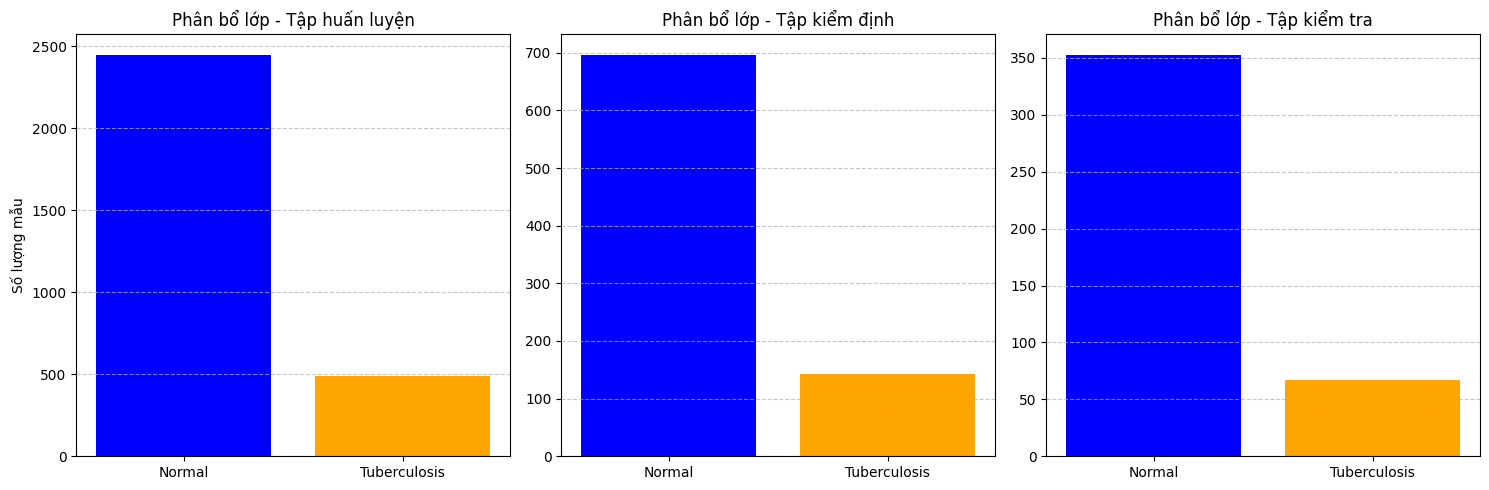

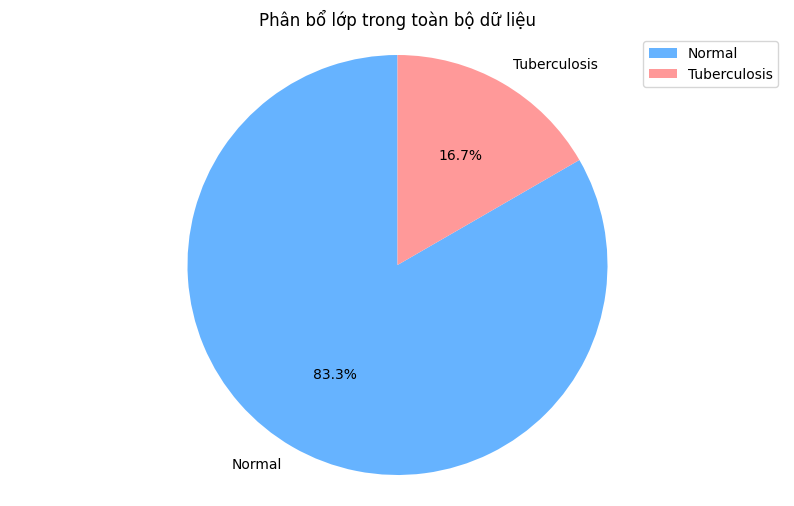

<Figure size 1200x600 with 0 Axes>

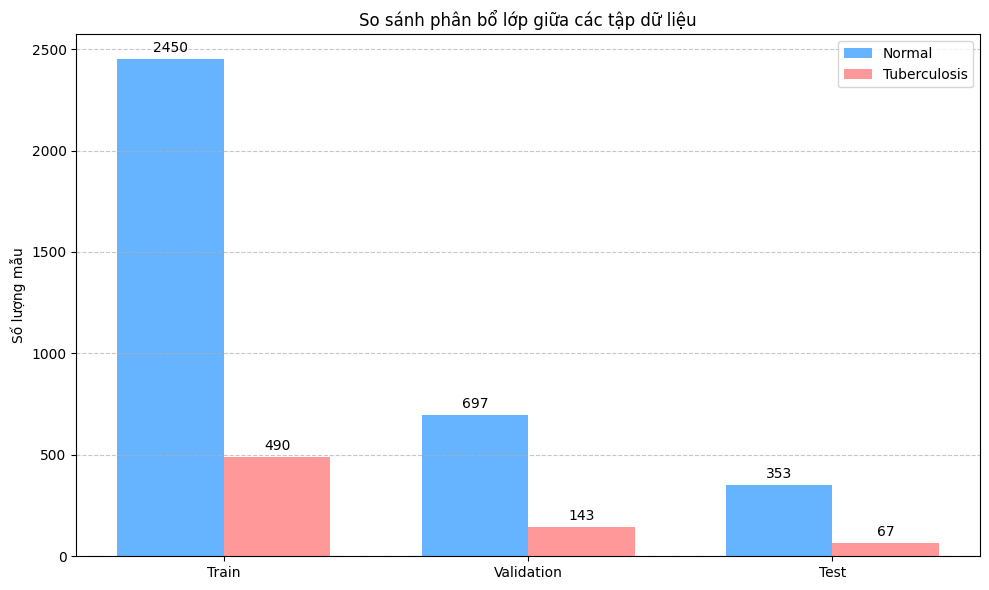

In [5]:
# Tạo biểu đồ phân bổ lớp cho từng tập dữ liệu
plt.figure(figsize=(15, 5))

# Biểu đồ cho tập huấn luyện
plt.subplot(1, 3, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values(), color=['blue', 'orange'])
plt.title('Phân bổ lớp - Tập huấn luyện')
plt.ylabel('Số lượng mẫu')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Biểu đồ cho tập kiểm định
plt.subplot(1, 3, 2)
plt.bar(val_class_counts.keys(), val_class_counts.values(), color=['blue', 'orange'])
plt.title('Phân bổ lớp - Tập kiểm định')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Biểu đồ cho tập kiểm tra
plt.subplot(1, 3, 3)
plt.bar(test_class_counts.keys(), test_class_counts.values(), color=['blue', 'orange'])
plt.title('Phân bổ lớp - Tập kiểm tra')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Tạo biểu đồ tròn cho phân bổ lớp trong toàn bộ dữ liệu
plt.figure(figsize=(10, 6))
plt.pie(class_counts.values(), labels=full_dataset.classes, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.axis('equal')
plt.title('Phân bổ lớp trong toàn bộ dữ liệu')
plt.legend()
plt.show()

# Tạo biểu đồ so sánh tỷ lệ phân bổ giữa các tập
plt.figure(figsize=(12, 6))

# Chuẩn bị dữ liệu
classes = full_dataset.classes
datasets = ['Train', 'Validation', 'Test']
normal_counts = [train_class_counts['Normal'], val_class_counts['Normal'], test_class_counts['Normal']]
tb_counts = [train_class_counts['Tuberculosis'], val_class_counts['Tuberculosis'], test_class_counts['Tuberculosis']]

x = np.arange(len(datasets))  # Vị trí của các nhóm
width = 0.35  # Độ rộng của các cột

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, normal_counts, width, label='Normal', color='#66b3ff')
rects2 = ax.bar(x + width/2, tb_counts, width, label='Tuberculosis', color='#ff9999')

# Thêm nhãn, tiêu đề và chú thích
ax.set_ylabel('Số lượng mẫu')
ax.set_title('So sánh phân bổ lớp giữa các tập dữ liệu')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# Thêm nhãn giá trị trên mỗi cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 điểm dọc trên cột
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 1)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
for param in model.fc.parameters():
    param.requires_grad = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# torchinfo.summary(
#     model,
#     input_size=(
#         32,
#         3,
#         224,
#         224,
#     ),
#     verbose=0,
#     col_names=["input_size", "output_size", "num_params", "trainable"],
#     col_width=20,
#     row_settings=["var_names"],
# )
summary = torchinfo.summary(
    model,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
)
print(summary)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10, eta_min=1e-6
)

In [ ]:
train_losses = []
val_losses = []
learning_rates = []
num_epochs = 10
best_val_loss = float("inf")
patience = 3
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_samples = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_samples += images.size(0)

    avg_train_loss = (
        train_loss / train_samples if train_samples > 0 else float("inf")
    )
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_samples = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.view(-1, 1).float()
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_samples += images.size(0)

            preds = torch.sigmoid(outputs) > 0.5
            val_preds.extend(preds.cpu().numpy().flatten())
            val_labels.extend(labels.cpu().numpy().flatten())

    avg_val_loss = val_loss / val_samples if val_samples > 0 else float("inf")
    val_losses.append(avg_val_loss)

    # Tính metrics
    accuracy = accuracy_score(val_labels, val_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_labels, val_preds, average="binary"
    )

    # Lưu learning rate
    current_lr = optimizer.param_groups[0]["lr"]
    learning_rates.append(current_lr)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(
        f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}"
    )
    print(f"Learning Rate: {current_lr:.6f}")

    # Lưu model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Model saved")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

In [ ]:
# Test phase
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_loss = 0.0
test_samples = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        test_samples += images.size(0)

        preds = torch.sigmoid(outputs) > 0.5
        test_preds.extend(preds.cpu().numpy().flatten())
        test_labels.extend(labels.cpu().numpy().flatten())

avg_test_loss = test_loss / test_samples if test_samples > 0 else float("inf")
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, test_preds, average="binary"
)

print(f"Test Loss: {avg_test_loss:.4f}")
print(
    f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}"
)

In [ ]:
# Visualize
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()